<a href="https://colab.research.google.com/github/KrishnanandSingh/EVA/blob/master/Phase2/S01NeuralWordEmbeddings/NeuralWordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for text processing
Derived from the book [Deep Learning by Python by Francois Chollet](http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf)

We will learn how to
- Turn raw text into something a neural network can process
- Use the Embedding layer in a Keras model to learn task-specific token embeddings
- Use pretrained word embeddings to get an extra boost on small natural-
language-processing problems

### One hot encoding

Neural networks work with numbers so to process our text data we need to convert our it into numbers somehow. One way is to associate a number for each character other is to do the same for words.

In [0]:
# character-level one hot encoding
import numpy as np
import string

samples = ['The cat sat on the mat.', 'The dog ate my homeworks.']

# get all ascii characters
characters = string.printable

# assign each character an index starting with 1
token_index = dict(zip(characters, range(1, len(characters) + 1)))

# specify max value for character length which will be apt for you dataset
max_sentence_length = 50

# vectorize the samples
results = np.zeros(shape=(len(samples), max_sentence_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1


In [0]:
# Word level one hot encoding

import numpy as np

# create list of samples from your dataset
# a sample can be a sentence or even a paragraph.
samples = ['The cat sat on the mat.', 'The dog ate my homeworks.']

# dict to maintain index of each word
token_index = {}

# for every word in the sample assign an index
# don't assign index 0 to word. why?
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

# We cannot process infinitely long sentences, there must be some limit to it.
# specify some value that would be enough for most of the samples in your dataset.
max_sentence_length = 10

# vectorize the samples
results = np.zeros(shape=(len(samples), max_sentence_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    # ignore sample after max_sentence_length
    for j, word in enumerate(sample.split()[:max_sentence_length]):
        index = token_index.get(word)
        results[i, j, index] = 1

### Using Keras for one hot encoding

Let's explore built in function of Keras to do word-level one hot encoding

In [3]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homeworks.']

# create a tokenizer that can hold only 1000 most common words
# tokenizer is similar to the token_indexer we created in the "Word level one hot encoding" example
tokenizer = Tokenizer(num_words=1000)

# go through my dataset, find top 1000 most common words,
# and create indexes for them
tokenizer.fit_on_texts(samples)

# convert each sample into array of indexes
# this is something that can be processed
sequences = tokenizer.texts_to_sequences(samples)

# convert list of texts to numpy matrix, other vecotrization methods are also supported
# value for existing words in a sample is 1. all other positions are 0
# shape is len(samples), 1000
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# tokenizer stores the index dict in this variable
# this can be used to map indexes back to the words later
word_index = tokenizer.word_index
print('Found {num} unique tokens.'.format(num = len(word_index)))


Using TensorFlow backend.


Found 9 unique tokens.


The drawback of previous examples is we have to maintain a dict for indexes of each word and this can grow huge when we have large number of unique words in our dataset. So, we can turn our words into vectors with simple hashing trick and store this key with the index.

In [0]:
# word level one hot encoding with hashing trick

samples = ['The cat sat on the mat.', 'The dog ate my homeworks.']

# stores words as vectors of size 1000
dimensionality = 1000
max_sentence_length = 10

results = np.zeros((len(samples), max_sentence_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_sentence_length]:
        # hash value is very big integer (~19 digits)
        hash_val = hash(word)
        positive_hash_val = abs(hash_val)
        # generate value for index
        index = positive_hash_val % dimensionality
        results[i, j, index] = 1.

# since the index is just a remainder, it can only be as large as the dimensionality
# choose it to be large enough to produce different values for different words
# must not be similar to the number of words we have

### Introduction to Word-Embeddings

Problem with above approaches of one hot encoding is that the vectors obtained are very sparse and are high dimensional. For example each sample would be converted to an array with as many elements as the unique words in our dataset (or max words length specified) and would consist of mostly zeros.

Word embeddings are low dimensional floating point vectors. They are learned from data. Each word is represented with some vector in such a way that they obtain some structure e.g. "exact" and "accurate" lie near to each other in the geometric space.

In [5]:
# To learn the embeddings from our dataset Keras comes up preloaded with a special layer

# Instantiating an embedding layer
from keras.layers import Embedding

# create embedding layer for at most 1000 possible tokens,
# and each token to be represented by vectors of size 64
embedding_layer = Embedding(1000, 64)
# Instead of words Embedding takes integer arrays (sequences)
# each integer is looked up for it's vector representation of 64 size

In [6]:
# Loading the IMDB data for use with an Embedding layer
from keras.datasets import imdb
from keras import preprocessing

max_tokens = 1000
max_sentence_length = 20

# downloads 25000 reviews for training and 25000 for testing
# ensure that word index does not exceed 1000
# as we have limited it to have only 1000 most frequently used words
# each word is represented as integer from the index dict
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_tokens)

# this is how each review can be decoded back
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
# indices are offset by 3 as 0, 1 and 2 are reserved indices for "padding", "start of sequence" and "unknown"

# pad with 0 to ensure that each sequence has same legth
# if maxlen is not provided it pads each sequence to the length of largest sequence in input array
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_sentence_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_sentence_length)

1646592/1641221 [==============================] - 1s 1us/step


In [7]:
# Using an Embedding layer and classifier on the IMDB data
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.datasets import imdb
from keras import preprocessing

max_tokens, dimensionality = 1000, 8
max_sentence_length = 20

model = Sequential()
embedding_layer = Embedding(max_tokens, dimensionality, input_length=max_sentence_length)
# max_tokens will be upper cap on keys in word_index
# after this layer output shape would be num of samples x max_sentence_length x dimensionality
model.add(embedding_layer)
# convert this 2D data to 1D
model.add(Flatten())
# add classifier
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Input pipeline
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_tokens)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_sentence_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_sentence_length)

# train for 10 epochs, reserve 20% train data for validation, don't train on it
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

# test score
model.evaluate(x_test, y_test)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             8000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 8,161
Trainable params: 8,161
Non-trainable params: 0
_________________________________________________________________



Train on 20000 samples, validate on 5000 samples
Epoch 1/10





20000/20000 [==============================] - 1s 70us/step - loss: 0.6629 - acc: 0.6282 - val_loss: 0.5991 - val_acc: 0.6968
Epoch 2/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.5375 - ac

[0.5666633911323548, 0.71568]

## Prepare data from scratch, tokenize and use a pre trained word embedding to train model

To learn how to prepare data from scratch, let's download raw imdb data and preprocess it. 

Download and extract the zip. Extracted folder has following structure.

```txt
aclImdb
  - test
    - neg
        0-3.txt
        .
    - pos
        1-10.txt
        .
  - train
    - neg
        0-3.txt
        .
    - pos
        1-10.txt
        .
```

Each .txt file contains either positive or negative review based on it's location.

In [0]:
!wget -q http://s3.amazonaws.com/text-datasets/aclImdb.zip
!unzip -q aclImdb.zip

In [0]:
import os

cwd = os.getcwd()
imdb_dir = os.path.join(cwd, 'aclImdb')
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            file_path = os.path.join(dir_name, fname)
            with open(file_path) as review_file:
                texts.append(review_file.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

test_labels = []
test_texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            file_path = os.path.join(dir_name, fname)
            with open(file_path) as review_file:
                test_texts.append(review_file.read())
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)

# All the reviews are stored in texts array and their sentiments in labels array

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# split into train and validation data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# prepare test data
test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(test_labels)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


We got our data ready. Now let's download a pretrained word-embedding. We use pretrained embeddings when our train data is sparse. When we have ample train data, learning our own embedding outperforms pre-trained ones.

We'll use Glove6B word-embedding available from https://nlp.stanford.edu/projects/glove/. It's trained on wikipedia 2014 and contains 6B tokens. We'll download it, parse it and prepare it to be used in model's Embedding layer.


In [0]:
# download glove embedding
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [19]:
# Parsing the GloVe word-embeddings file
import os

cwd = os.getcwd()
embeddings_index = {}
# Each line in the extracted file starts with a word and has float values delimited by space
with open(os.path.join(cwd, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

# for each index in our word_index (created by tokenizer) associate the word's embedding vector
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Found 400000 word vectors.


In [20]:
# Model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
# Do not train this layer
model.layers[0].trainable = False

In [22]:
# Training and evaluation
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.7532 - acc: 0.5000 - val_loss: 0.6903 - val_acc: 0.5417
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5447 - acc: 0.7150 - val_loss: 0.7670 - val_acc: 0.5118
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4297 - acc: 0.8200 - val_loss: 0.8329 - val_acc: 0.5050
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3814 - acc: 0.8400 - val_loss: 0.7322 - val_acc: 0.5299
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2975 - acc: 0.9700 - val_loss: 0.7230 - val_acc: 0.5443
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2342 - acc: 0.9350 - val_loss: 0.8561 - val_acc: 0.5229
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1483 - acc: 0.9650 - val_loss: 0.7534 - val_acc: 0.5535
Epoch 8/10
200/200 [========

In [0]:
# Plotting the results
import matplotlib.pyplot as plt

def plot_accuracy_and_loss_graph(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

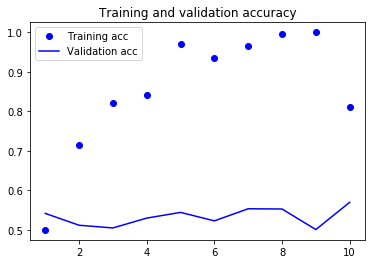

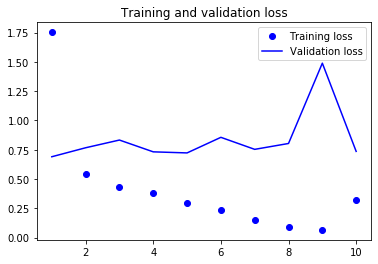

In [23]:
plot_accuracy_and_loss_graph(history)

Training the same model without pretrained word embeddings

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6958 - acc: 0.4600 - val_loss: 0.6917 - val_acc: 0.5223
Epoch 2/10
200/200 [==============================] - 1s 3ms/s

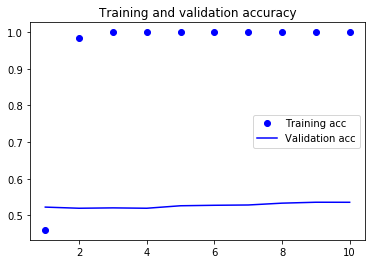

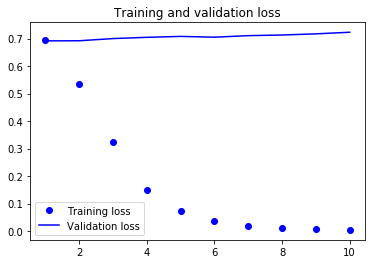

In [31]:
plot_accuracy_and_loss_graph(history)

Loading and evaluating the first model

In [27]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 49us/step


[0.7342179582595825, 0.57068]

We see that training with jointly learned embeddings performed poorly than the pre trained embeddings. Let's try training again with more train data.

In [0]:
training_samples = 8000
validation_samples = 10000

# split into train and validation data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 6s 709us/step - loss: 0.5515 - acc: 0.7049 - val_loss: 0.3875 - val_acc: 0.8259
Epoch 2/10
8000/8000 [==============================] - 5

In [34]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 51us/step


[0.6841680439170823, 0.87584]

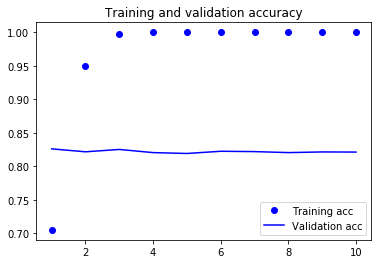

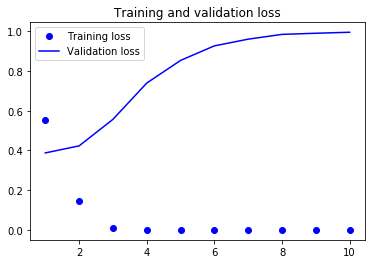

In [35]:
plot_accuracy_and_loss_graph(history)

## Assignment 

Train the GLOVE based model with 8000 samples instead of 200.

In [0]:
training_samples = 8000
validation_samples = 10000

# split into train and validation data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential(name='Glove model with 8k train')
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "Glove model with 8k train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
# Do not train this layer
model.layers[0].trainable = False

In [41]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 313us/step - loss: 0.7113 - acc: 0.5106 - val_loss: 0.6933 - val_acc: 0.4934
Epoch 2/10
8000/8000 [==============================] - 2s 265us/step - loss: 0.6724 - acc: 0.5971 - val_loss: 1.0769 - val_acc: 0.5167
Epoch 3/10
8000/8000 [==============================] - 2s 266us/step - loss: 0.5672 - acc: 0.7086 - val_loss: 0.5744 - val_acc: 0.7014
Epoch 4/10
8000/8000 [==============================] - 2s 261us/step - loss: 0.4729 - acc: 0.7757 - val_loss: 0.5754 - val_acc: 0.7000
Epoch 5/10
8000/8000 [==============================] - 2s 264us/step - loss: 0.4149 - acc: 0.8151 - val_loss: 0.5881 - val_acc: 0.7097
Epoch 6/10
8000/8000 [==============================] - 2s 258us/step - loss: 0.3564 - acc: 0.8410 - val_loss: 0.6162 - val_acc: 0.6977
Epoch 7/10
8000/8000 [==============================] - 2s 263us/step - loss: 0.3065 - acc: 0.8714 - val_loss: 0.6544 - val_acc: 0.6990

In [42]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 50us/step


[0.6199846486377716, 0.78048]

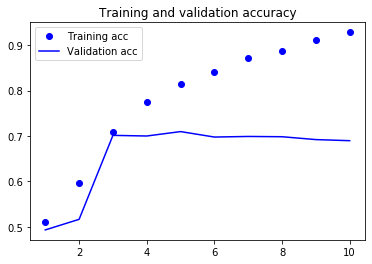

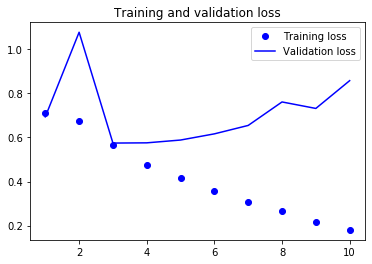

In [43]:
plot_accuracy_and_loss_graph(history)